There is no need for a comprehensive data set of features and labels to be given up front. The data is rather generated by the learning agent while interacting with the environment of interest.

# Fundamental Notions

- Environment : defines the problem at hand.

- State : subsumes all relevant parameters that decribe the current state of the environment.

- Agent : subsumes all elements of the RL algorithm that interacts with the enviromment and that learns form these interactions.

- Action : An agent can choose one action form a set of allowed actions.

- Step : Given an action of an agent, the state of the environment is updated. One such a update is generally caled a step.

- Reward : Depending on an agent chooses, a reward (or penalty) is awarded.

- Target : The target specifies what agent tries to maximize.

- Policy : defines which action an agent takes given a certain state of the environment.

- Episode : is a set of steps from the initial state of the environment until success is achieved or failure is observed.

# [OpenAI Gym](https://openai.com/research/openai-gym-beta)

Among many environments, there is the [CartPole](https://github.com/openai/gym/wiki/CartPole-v0) environment that simulates a classical RL problem. The state of the environment is given by four parameters: cart position, cart velocity, pole angle, and pole velocity.

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import gym

In [4]:
# the environment object, with fixed seed values
env = gym.make('CartPole-v0')
# env.seed(100)
obs, info = env.reset(seed=100)
env.action_space.seed(100)

[100]

In [5]:
# the observation space with minimal and maximal values
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [6]:
env.observation_space.low.astype(np.float16)

array([-4.8  ,   -inf, -0.419,   -inf], dtype=float16)

In [7]:
env.observation_space.high.astype(np.float16)

array([4.8  ,   inf, 0.419,   inf], dtype=float16)

In [8]:
# reset of the environment
state = env.reset()

In [10]:
# initial sate: cart position, cart velocity, pole angle, pole angualr velocity
state

(array([0.04736544, 0.00964717, 0.02902632, 0.04103394], dtype=float32), {})

In [11]:
# the action space
env.action_space

Discrete(2)

In [12]:
env.action_space.n

2

In [13]:
# random action sampled from the action space
env.action_space.sample()

1

In [14]:
env.action_space.sample()

1

In [15]:
a = env.action_space.sample()
a

0

In [16]:
# step forward based on random action
state, reward, trunc, done, info = env.step(a)
# new state of the environment, reward, sucess/failure, additional information
state, reward, trunc, done, info

(array([ 0.04755838, -0.18587872,  0.029847  ,  0.34273177], dtype=float32),
 1.0,
 False,
 False,
 {})

Success is achieved when the agent reaches a total of 200 steps in a row or a total reward of 200. A failure is observed when the pole on the cart reaches a certain angle that would lead to the pole falling from the cart. In that case `done=True` is returned.

A simple agent is one that follows a completely random policy.

In [17]:
# a simple agent
env.reset()
for e in range(1, 200):
    # random action policy
    a = env.action_space.sample()
    state, reward, done, trunc, info = env.step(a)
    print(f'step={e:2d} | state={state} | action={a} | reward={reward}')

    if done and (e + 1) < 200:
        print('*** FAILED ***')
        break

step= 1 | state=[ 0.01819543  0.16339873  0.04771738 -0.29863742] | action=1 | reward=1.0
step= 2 | state=[ 0.0214634  -0.03236978  0.04174463  0.00870468] | action=0 | reward=1.0
step= 3 | state=[ 0.02081601 -0.22806478  0.04191872  0.31426078] | action=0 | reward=1.0
step= 4 | state=[ 0.01625471 -0.423758    0.04820394  0.6198633 ] | action=0 | reward=1.0
step= 5 | state=[ 0.00777955 -0.6195189   0.0606012   0.92732996] | action=0 | reward=1.0
step= 6 | state=[-0.00461083 -0.42526525  0.07914781  0.65429026] | action=1 | reward=1.0
step= 7 | state=[-0.01311613 -0.23132934  0.09223361  0.38754225] | action=1 | reward=1.0
step= 8 | state=[-0.01774272 -0.0376294   0.09998445  0.12530558] | action=1 | reward=1.0
step= 9 | state=[-0.01849531  0.15592858  0.10249057 -0.13423489] | action=1 | reward=1.0
step=10 | state=[-0.01537674 -0.04050072  0.09980587  0.18894239] | action=0 | reward=1.0
step=11 | state=[-0.01618675  0.15306221  0.10358471 -0.07066289] | action=1 | reward=1.0
step=12 | 

In [18]:
done

True

# Monte Carlo Agent

This section presents a simple solution to the problem based on Monte Carlo simulation. To this end, a specific policy is defined that makes use of dimensionality reduction. In that case, the four parameters defining a state of the environment are collapsed, via a linear combination, into a single real-valued parameter.

In [27]:
# random weights for fixed seed value
np.random.seed(100)
weights = np.random.random(4) * 2 - 1
weights

array([ 0.08680988, -0.44326123, -0.15096482,  0.68955226])

In [28]:
# initial state of the environment
state = env.reset()[0]
state

array([ 0.04976745,  0.04786219, -0.0106432 , -0.01780747], dtype=float32)

In [29]:
# dot product of state and weights
s = np.dot(state, weights)
s

-0.027567583254109705

In [30]:
# the policy based on the sign of the single state parameter `s`
if s < 0:
    a = 0
else:
    a = 1
a

0

Given the random nature of the weights applie, the resuls are in general not bettern than those of the random action policy of the previous section (textbook). In my case, much better.

In [34]:
def run_episode(env, weights):
    state = env.reset()[0]
    treward = 0
    for _ in range(200):
        s = np.dot(state, weights)
        a = 0 if s < 0 else 1
        state, reward, done, trunc, info = env.step(a)

        treward += reward
        if done:
            break

    return treward

In [35]:
run_episode(env, weights)

86.0

Monte Carlo simulation is applied to test a large number of different weights.

In [37]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    # env.seed(seed)

In [38]:
set_seeds()
num_episodes = 1000

In [39]:
bestreward = 0
for e in range(1, num_episodes + 1):
    weights = np.random.rand(4) * 2 - 1
    treward = run_episode(env, weights)
    if treward > bestreward:
        bestreward = treward
        bestweights = weights
        if treward == 200:
            print(f'SUCCESS | episode={e}')
            break
        print(f'UPDATE | episode={e}')

UPDATE | episode=1
UPDATE | episode=2
SUCCESS | episode=13


In [40]:
weights

array([-0.42820862,  0.70479018,  0.95001299,  0.76970659])

The `CartPole` problem is considered solved by an agent if the average total reward over 100 consecutive episodes is 195 or higher. This is indeed the case for the Monte Carlo agent.

In [41]:
res = []
for _ in range(100):
    treward = run_episode(env, weights)
    res.append(treward)

res[:10]

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]

In [42]:
sum(res) / len(res)

200.0

# Neural Network Agent

The `CartPole` game can be cast into a classification setting. The state of an environment consists of four feature values. The correct action given the feature values is the label. Given this incrementally growing data set, a neural network can be trained to learn the correct action given a state of the environment.

In [54]:
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score
from tensorflow.keras import optimizers

In [55]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [56]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # env.seed(seed)
    env.action_space.seed(seed)

Second is the `NNAgent` class that conbines the major element of the agent: the neural network model for the policy, choosing an action given the policy, updating the policy, and the learning process itset over a number of episodes.

The agent uses both exploration and exploitation to choose an action, independent of the current random choice. Explotation refers to an action as derviced from the current policy. The idea is that some degree of exploration ensures a richer experience and thereby improved learning for the agent.

In [57]:
a = env.reset()[0]
a

array([ 0.03508671, -0.00740771,  0.03893986,  0.03937816], dtype=float32)

In [65]:
class NNAgent:
    def __init__(self):
        # the maximum total reward
        self.max = 0
        self.scores = list()
        self.memory = list()
        self.model = self._build_model()

    # the DNN classification model for the policy
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=4,
                        activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(learning_rate=0.001))
        return model

    # the method to choose an action (exploration and exploitation)
    def act(self, state):
        if random.random() <= 0.5:
            return env.action_space.sample()
        action = np.where(self.model.predict(
            state, batch_size=None)[0, 0] > 0.5, 1, 0)
        return action

    # the method to update the policy (train the neural network)
    def train_model(self, state, action):
        self.model.fit(state, np.array([action,]),
                       epochs=1, verbose=False)

    # the method to learn from interacting with the environment
    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = env.reset()[0]
            for _ in range(201):
                state = np.reshape(state, [1, 4])
                action = self.act(state)
                next_state, reward, done, trunc, info = env.step(action)

                if done:
                    score = _ + 1
                    self.scores.append(score)
                    # maximum total reward
                    self.max = max(score, self.max)
                    print('episode: {:4d}/{} | score: {:3d} | max: {:3d}'
                          .format(e, episodes, score, self.max), end='\r')
                    break

                self.memory.append((state, action))
                self.train_model(state, action)
                state = next_state

In [66]:
set_seeds(100)
agent = NNAgent()

In [67]:
episodes = 1000

In [68]:
agent.learn(episodes)

In [69]:
sum(agent.scores) / len(agent.scores)

37.838

One major missing element is the idea of looking beyond the current state and action to be chosen. The approach implemented does not take into account that success is only achieved when the agent survives 200 consecutive steps. That is, the agent avoids taking the wrong action but does not learn to win the game.

In [71]:
# features (states) from all episodes
f = np.array([m[0][0] for m in agent.memory])
f

array([[-0.01314256,  0.0381567 , -0.01466641, -0.0339686 ],
       [-0.01237943,  0.23348586, -0.01534578, -0.33124262],
       [-0.00770971,  0.03858568, -0.02197063, -0.04343823],
       ...,
       [ 0.03739378, -0.167632  , -0.17605469, -0.20372455],
       [ 0.03404114,  0.02951338, -0.18012917, -0.5463646 ],
       [ 0.03463141,  0.22664797, -0.19105648, -0.88995427]],
      dtype=float32)

In [72]:
# Labels (actions) from all episdes
l = np.array([m[1] for m in agent.memory])
l

array([1, 0, 0, ..., 1, 1, 0])

In [73]:
agent.model.predict(f)

array([[0.79238427],
       [0.62570727],
       [0.7976289 ],
       ...,
       [0.8752328 ],
       [0.8293216 ],
       [0.40934202]], dtype=float32)

In [74]:
accuracy_score(np.where(agent.model.predict(f) > 0.5, 1, 0), l)

0.6019056409142733

Analyzing the collected history of states (features) and actions (labels) reveals that the neural network reaches an accuracy of acount 60%.

However, this does not translate into a winning policy as seen before.

# DQL Agent

Q-Learining (QL) is an algorithm that takes into account delayed rewards in addition to immediate rewards from an action.

The algorithm works roughly as follows. There is an action-value policy $Q$, which assigns a value to every combination of a state and a action. The higher the value is, the better the action from the point of view of the agent will be. If the agent uses the policy $Q$ to choose an action, it selects the action with the highest value.

The value of an action is composed of its direct reward and the discounted value of the optimal action in the next state.
$$Q(S_t, A_t)=R_{t+1}+γ\max_a Q (S_{t+1}, a)$$

- $S_t$ : the state at step (time) $t$
- $A_t$ : the action taken at state $S_t$
- $R_{t+1}$ : the direct reward of action $A_t$
- $0<γ<1$ : a discount factor
- $\max_a A(S_{t+1},a)$ : the maximum delayed reward given optimal action from the current policy $Q$

In a simnple environment, $Q$ can be represented by a table, listing for every state-action combination the corresponding value. In more complex setting, the number of states is too large for $Q$. Therefore, $Q$ is in general undestood to be a function.

In realistric setting, a closed-form solution for the function $Q$ might not exist or might be too hard to derive. QL algorithm generally target approximation only. Neural networks, with their universal approximation capabilities, are a natural choice to accomplish the approximation of $Q$.

Another critical element of QL is replay. The QL agent replays a number of experiences (state-action combinations) to update the policy $Q$ regularly. This can improve learning considerably. Futthemore, `DQLAgent` alternates between exploration and exploitation during the learning. The alternation is done in a systematic way in that the agent starts with exploration only and slowly but steadily decreases the exploration rate $ϵ$ until it reaches a minimum level.

In [75]:
from collections import deque
from keras.optimizers import Adam, RMSprop

In [87]:
class DQLAgent:
    def __init__(self, gamma=0.95, hu=24, opt=Adam,
           lr=0.001, finish=False):
        self.finish = finish
        # initial exploration rate
        self.epsilon = 1.0
        # minimum exploration rate
        self.epsilon_min = 0.01
        # decay rate for exploaration rate
        self.epsilon_decay = 0.995
        # discount factor for dealyed reward
        self.gamma = gamma
        # bathc size for replay
        self.batch_size = 32
        self.max_treward = 0
        self.averages = list()
        # deque collection for limited history
        self.memory = deque(maxlen=2000)
        self.osn = env.observation_space.shape[0]
        self.model = self._build_model(hu, opt, lr)


    def _build_model(self, hu, opt, lr):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.osn,
                        activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=opt(learning_rate=lr))
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return env.action_space.sample()
        action = self.model.predict(state)[0]
        return np.argmax(action)

    def replay(self):
        # random selection of history batch for replay
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                # Q value for state-action pair
                reward += self.gamma * np.amax(self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0, action] = reward
            # update of the neural network for the new action-value pairs
            self.model.fit(state, target, epochs=1,
                           verbose=False)

        if self.epsilon > self.epsilon_min:
            # update of the exploration rate
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()[0]
            state = np.reshape(state, [1, self.osn])
            for _ in range(5000):
                action = self.act(state)
                next_state, reward, done, trunc, info = env.step(action)
                next_state = np.reshape(next_state,
                                        [1, self.osn])
                # storing the new data
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state

                if trunc:
                    treward = _ + 1
                    trewards.append(treward)
                    av = sum(trewards[-25:]) / 25
                    self.averages.append(av)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:4d}/{} | treward: {:4d} | '
                    templ += 'av: {:6.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, av,
                                       self.max_treward), end='\r')
                    break

            if av > 195 and self.finish:
                print()
                break
            if len(self.memory) > self.batch_size:
                self.replay()

    # replay to update the policy based on experiences
    def test(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()[0]
            for _ in range(5001):
                state = np.reshape(state, [1, self.osn])
                action = np.argmax(self.model.predict(state)[0])
                next_state, reward, done, trunc, info = env.step(action)
                state = next_state
                if trunc:
                    treward = _ + 1
                    trewards.append(treward)
                    print('episode: {:4d}/{} | treward: {:4d}'
                          .format(e, episodes, treward), end='\r')
                    break
        return trewards

In [88]:
episodes = 1000

In [89]:
set_seeds(100)
agent = DQLAgent(finish=True)

In [90]:
%time agent.learn(episodes)

episode:   25/1000 | treward:  200 | av:  200.0 | max:  200
Wall time: 1.38 s


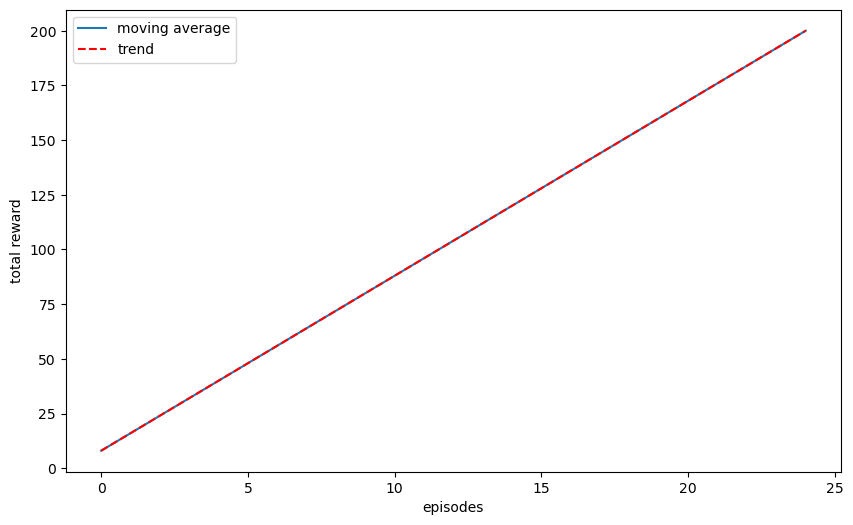

In [91]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='trend')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend()

In [92]:
trewards = agent.test(100)

In [93]:
sum(trewards) / len(trewards)

200.0

# Simple Finance Gym

This section provides a class that mimics an OpenAI Gym enviroment, but for a financial market. The idea is that four historical prices represent the state of the financial market. An agent can decide, when presented with the state, whether to go long or to go short.

In [95]:
class observation_space:
    def __init__(self, n):
        self.shape = (n, )

In [96]:
class action_space:
    def __init__(self, n):
        self.n = n

    def seed(self, seed):
        pass

    def sample(self):
        return random.randint(0, self.n - 1)

The Finance class retrieves end-of-day historical prices for a number of symbols. The major methods of the class are `.reset()` and `.step()`. The `.step()` method checks whether the right action has been taken, defines the reward accordingly, check for success or failure.

A success is achieved when the agent is able to correctly trade through the whole date set. This can be defined differently (say, a success is achieved when the agent trades successfully for 1,000 steps). A failure is defined as an accuracy ratio of less than 50%. However, this is only checked for after a certain number of steps to avoid the high initial variance of this metric.

In [119]:
class Finance:
    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
    def __init__(self, symbol, features):
        self.symbol = symbol
        self.features = features
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(2)
        # defines the minimum accuracy required
        self.min_accuracy = 0.475
        self._get_data()
        self._prepare_data()

    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()

    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data = (self.data - self.data.mean()) / self.data.std()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)

    def _get_state(self):
        # selects the data defining the state of the financial market
        return self.data[self.features].iloc[
            self.bar - self.osn:self.bar].values

    def seed(self, seed=None):
        pass

    # resets the environment to its initial values
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.osn
        state = self.data[self.features].iloc[
            self.bar - self.osn:self.bar]
        return state.values, {}

    def step(self, action):
        trunc = False
        # checks whether the agent has chosen the right action (successful trade)
        correct = action == self.data['d'].iloc[self.bar]
        # defines the reward the agent receives
        reward = 1 if correct else 0
        # adds the reward the agent recieves
        self.treward += reward
        # moves the environment one step forward
        self.bar += 1
        # calculates the accuracy of successful actions (trades) given all steps (trades)
        self.accuracy = self.treward / (self.bar - self.osn)

        # if the agent reaches the end of the data set, success is achived
        if self.bar >= len(self.data):
            done = True
            trunc = True
        # if the agent takes the right action, it can move on
        elif reward == 1:
            done = False
        # if, after some initial step, the accuracy drops under the minimum level, the episode ends
        elif (self.accuracy < self.min_accuracy and self.bar > self.osn + 10):
            done = True
            trunc = True
        # for the remaining cases, the agent can move on.
        else:
            done = False

        state = self._get_state()
        info = {}
        return state, reward, done, trunc, info


`Finance` class behave like an environment of the OpenAI Gym. The instance behaves exactly like the `CartPole` environment

In [120]:
# specifies which symbol and which type of feature to be used to define the data representing the state
env = Finance('EUR=', 'EUR=')

In [121]:
env.reset()

(array([1.81901285, 1.85786346, 1.77486442, 1.85786346]), {})

In [122]:
a = env.action_space.sample()
a

0

In [123]:
env.step(a)

(array([1.85786346, 1.77486442, 1.85786346, 1.94704329]), 0, False, False, {})

`DQLAgent` for the `CartPole` learns to trade in a financial market. However, although the agent improves its trading skill over the training episodes, the results are not too impressive.

In [124]:
set_seeds(100)
agent = DQLAgent(gamma=0.5, opt=RMSprop)

In [125]:
episodes = 1000

In [126]:
%time agent.learn(episodes)

Wall time: 12min 58s treward: 2511 | av: 1647.2 | max: 2511


In [127]:
agent.test(3)

[2511, 2511, 2511]

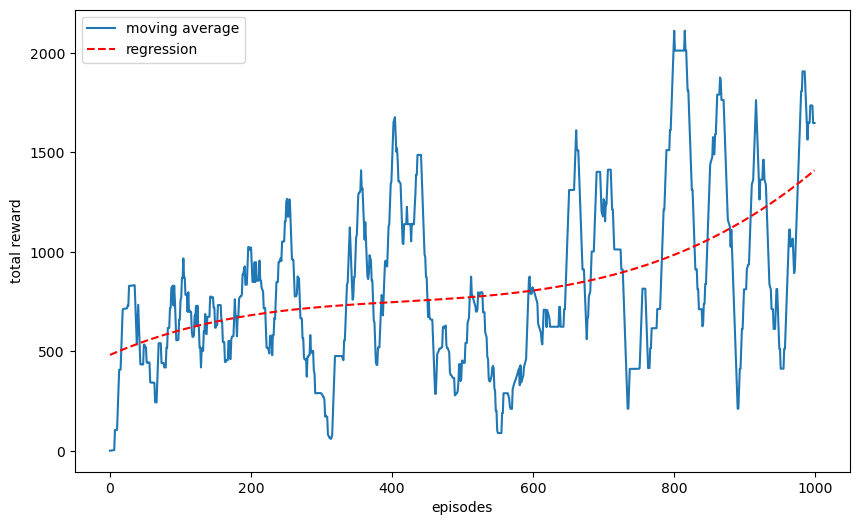

In [128]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend()

This section provides a class for a financial market environment that mimics the API of an Open AI Gym environment.

Although the performance of the agent in this new environment might not be impressive, it illustrates that the approach of RL is rather general. RL agents can in general learn from different environmentss they interact with.

# Better Finance Gym

This section introduces an improved `Finance` class that allows for multiple features, a flexible number of lags, and specific start and end points for the base data set used. This allows the use of one part of the data set for learning and another one for validation or testing.

This might be helpful when intraday is considered with relatively small absolute returns.

In [129]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [130]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score

In [131]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [132]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)
    env.action_space.seed(100)

In [133]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [134]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        pass
    def sample(self):
        return random.randint(0, self.n - 1)

In [140]:
class Finance:
    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

    def __init__(self, symbol, features, window, lags,
                 leverage=1, min_performance=0.85,
                 start=0, end=None, mu=None, std=None):
        self.symbol = symbol
        self.features = features
        # the features to define the state
        self.n_features = len(features)
        self.window = window
        # the number of lags to be used
        self.lags = lags
        self.leverage = leverage
        # the minimum gross performance required
        self.min_performance = min_performance
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.observation_space = observation_space(self.lags)
        self.action_space = action_space(2)
        self._get_data()
        self._prepare_data()

    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()

    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data = self.data.iloc[self.start:]
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        # additional financial features (simple moving average, momentum, rolling volatility)
        self.data['s'] = self.data[self.symbol].rolling(self.window).mean()
        self.data['m'] = self.data['r'].rolling(self.window).mean()
        self.data['v'] = self.data['r'].rolling(self.window).std()
        self.data.dropna(inplace=True)
        # Gaussian normalization of the data
        if self.mu is None:
            self.mu = self.data.mean()
            self.std = self.data.std()
        self.data_ = (self.data - self.mu) / self.std
        self.data_['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data_['d'] = self.data_['d'].astype(int)
        if self.end is not None:
            self.data = self.data.iloc[:self.end - self.start]
            self.data_ = self.data_.iloc[:self.end - self.start]

    def _get_state(self):
        return self.data_[self.features].iloc[self.bar - self.lags : self.bar]

    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        self.bar = self.lags
        state = self.data_[self.features].iloc[self.bar-
                        self.lags:self.bar]
        return state.values

    def step(self, action):
        correct = action == self.data_['d'].iloc[self.bar]
        # the leveraged return for the step
        ret = self.data['r'].iloc[self.bar] * self.leverage
        reward_1 = 1 if correct else 0
        # the return-based reward for the step
        reward_2 = abs(ret) if correct else -abs(ret)
        factor = 1 if correct else -1
        self.treward += reward_1
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags)
        self.performance *= math.exp(reward_2)
        # the gross performance after the step
        if self.bar >= len(self.data):
            done = True
        elif reward_1 == 1:
            done = False
        elif (self.performance < self.min_performance and
              self.bar > self.lags + 5):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state.values, reward_1 + reward_2 * 5, done, info


In [136]:
env = Finance('EUR=', ['EUR=', 'r'], 10, 5)

In [137]:
a = env.action_space.sample()
a

1

In [138]:
env.reset()

array([[ 1.77206055, -1.02135357],
       [ 1.59731584, -2.44318439],
       [ 1.58755852, -0.12078195],
       [ 1.62924888,  0.60830363],
       [ 1.64078026,  0.18066537]])

In [139]:
env.step(a)

(array([[ 1.59731584, -2.44318439],
        [ 1.58755852, -0.12078195],
        [ 1.62924888,  0.60830363],
        [ 1.64078026,  0.18066537],
        [ 1.57247903, -0.95019257]]),
 -0.027282780374079853,
 False,
 {})

There is a fundamental difference between the `CartPole` environment and the two versions of the `Finance` environment.

In the `CartPole` environment, no data is available up front. Only an initial state is chosen with some degree of randomness. Given this state and the action taken by an agent, deterministic transformations are applied to generate new states (data). This is possible since a physical system is simulated that follows physical laws.

The `Finance` environment starts with real, historical market data and only presents the available data to the agent in similar fashion as the `CartPole` environment. The action of the agent does not really influence the environment; the environment instead evolves deterministically, and the agent learns how to behave optimally in that environment.

In that sense, the `Finance` environment is more comparable to the problem of finding the fastest way through a labyrinth. In such a case, the data representing the labyrinth is given up front and the agent is only presented with the relevant sub-set of the data (the current-sate) as it moves around the labyrinth.

# FQL Agent

This section improves on the simple DQL agent to improve the performance in the financail market context. The `FQLAgent` class is able to handle multiple features and a flexible number of lags. It also distinguishes the learning environment (`learn_env`) from the validation environment(`valid_env`). The basic structure of the class and the RL/QL learning approach is the same for both `DQLAgent` class and the `FQLAgent` class.

In [141]:
class FQLAgent:
    def __init__(self, hidden_units, learning_rate, learn_env, valid_env):
        self.learn_env = learn_env
        self.valid_env = valid_env
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.98
        self.learning_rate = learning_rate
        self.gamma = 0.95
        self.batch_size = 128
        self.max_treward = 0
        self.trewards = list()
        self.averages = list()
        self.performances = list()
        self.aperformances = list()
        self.vperformances = list()
        self.memory = deque(maxlen=2000)
        self.model = self._build_model(hidden_units, learning_rate)

    def _build_model(self, hu, lr):
        model = Sequential()
        model.add(Dense(hu, input_shape=(
            self.learn_env.lags, self.learn_env.n_features),
                        activation='relu'))
        model.add(Dropout(0.3, seed=100))
        model.add(Dense(hu, activation='relu'))
        model.add(Dropout(0.3, seed=100))
        model.add(Dense(2, activation='linear'))
        model.compile(
            loss='mse',
            optimizer=RMSprop(learning_rate=lr)
        )
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.learn_env.action_space.sample()
        action = self.model.predict(state)[0, 0]
        return np.argmax(action)

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0, 0])
            target = self.model.predict(state)
            target[0, 0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = self.learn_env.reset()
            state = np.reshape(state, [1, self.learn_env.lags,
                                       self.learn_env.n_features])
            for _ in range(10000):
                action = self.act(state)
                next_state, reward, done, info = self.learn_env.step(action)
                next_state = np.reshape(next_state,
                                [1, self.learn_env.lags,
                                 self.learn_env.n_features])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    perf = self.learn_env.performance
                    self.averages.append(av)
                    self.performances.append(perf)
                    self.aperformances.append(
                        sum(self.performances[-25:]) / 25)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:2d}/{} | treward: {:4d} | '
                    templ += 'perf: {:5.3f} | av: {:5.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, perf,
                                  av, self.max_treward), end='\r')
                    break
            self.validate(e, episodes)
            if len(self.memory) > self.batch_size:
                self.replay()
    def validate(self, e, episodes):
        state = self.valid_env.reset()
        state = np.reshape(state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
        for _ in range(10000):
            action = np.argmax(self.model.predict(state)[0, 0])
            next_state, reward, done, info = self.valid_env.step(action)
            state = np.reshape(next_state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
            if done:
                treward = _ + 1
                perf = self.valid_env.performance
                self.vperformances.append(perf)
                if e % 20 == 0:
                    templ = 71 * '='
                    templ += '\nepisode: {:2d}/{} | VALIDATION | '
                    templ += 'treward: {:4d} | perf: {:5.3f} | '
                    templ += 'eps: {:.2f}\n'
                    templ += 71 * '='
                    print(templ.format(e, episodes, treward,
                                       perf, self.epsilon))
                break

In [142]:
symbol = 'EUR='
features = [symbol, 'r', 's', 'm', 'v']

In [143]:
a = 0
b = 2000
c = 500

In [144]:
learn_env = Finance(symbol, features, window=10, lags=6,
                    leverage=1, min_performance=0.85,
                    start=a, end=a+b, mu=None, std=None)

In [145]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2010-01-19 to 2017-12-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2000 non-null   float64
 1   r       2000 non-null   float64
 2   s       2000 non-null   float64
 3   m       2000 non-null   float64
 4   v       2000 non-null   float64
dtypes: float64(5)
memory usage: 93.8 KB


In [146]:
valid_env = Finance(symbol, features, window=learn_env.window,
                    lags=learn_env.lags, leverage=learn_env.leverage,
                    min_performance=learn_env.min_performance,
                    start=a+b, end=a+b+c,
                    mu=learn_env.mu, std=learn_env.std)

In [147]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2017-12-27 to 2019-12-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    500 non-null    float64
 1   r       500 non-null    float64
 2   s       500 non-null    float64
 3   m       500 non-null    float64
 4   v       500 non-null    float64
dtypes: float64(5)
memory usage: 23.4 KB


In [148]:
set_seeds(100)
agent = FQLAgent(24, 0.0001, learn_env, valid_env)

In [149]:
episodes = 61

In [150]:
%time agent.learn(episodes)

episode: 20/61 | VALIDATION | treward:  494 | perf: 1.004 | eps: 0.68
episode: 40/61 | VALIDATION | treward:  494 | perf: 0.914 | eps: 0.45
episode: 60/61 | VALIDATION | treward:  494 | perf: 0.918 | eps: 0.30
Wall time: 1min 1sreward:   78 | perf: 0.846 | av: 1112.0 | max: 1994


In [151]:
agent.epsilon

0.291602079838278

<function matplotlib.pyplot.legend(*args, **kwargs)>

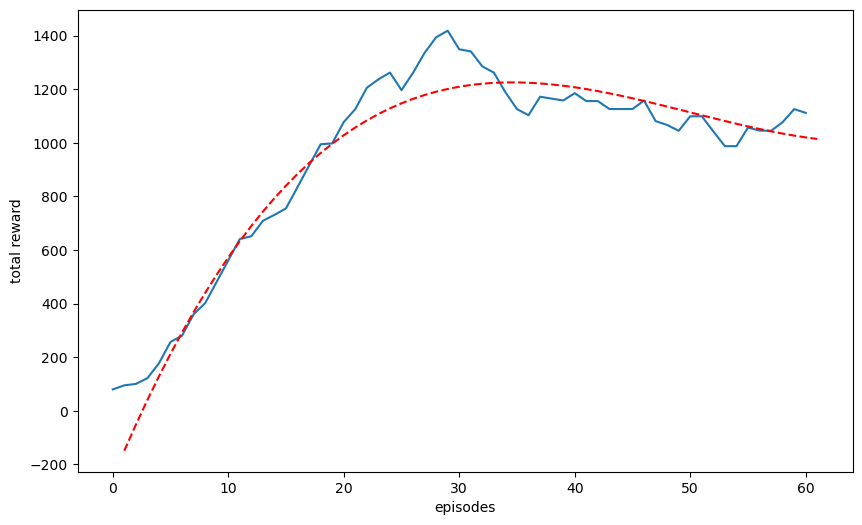

In [152]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.averages) + 1)
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving averages')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend

An interesting picture also arises for the training and validation performances. The training performance shows a high variance, which is due to the exploration that is going on in addition to the exploitation of the currently optimal policy. The validation performances has a much lower variance because it only relies on the exploitation of the currently optimal policy.

In [153]:
len(agent.performances)

61

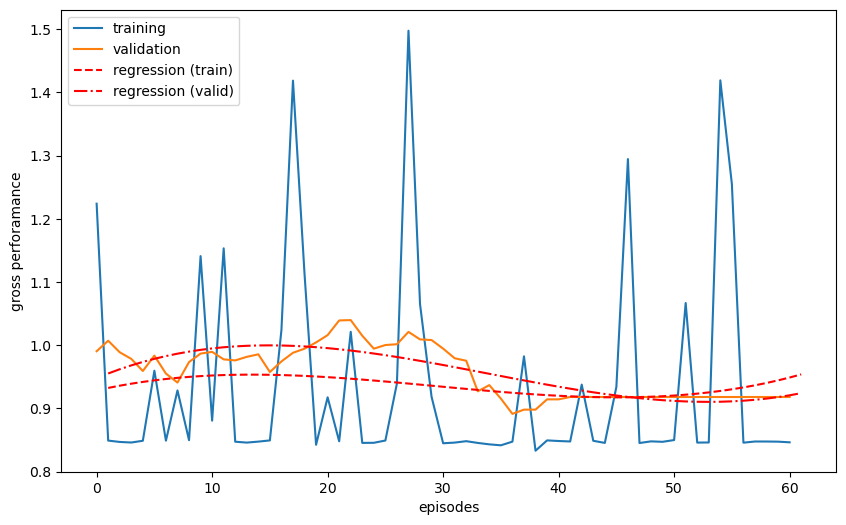

In [154]:
plt.figure(figsize=(10, 6))
x = range(1, (len(agent.performances) + 1))
y = np.polyval(np.polyfit(x, agent.performances, deg=3), x)
y_ = np.polyval(np.polyfit(x, agent.vperformances, deg=3), x)
plt.plot(agent.performances[:], label='training')
plt.plot(agent.vperformances[:], label='validation')
plt.plot(x, y, 'r--', label='regression (train)')
plt.plot(x, y_, 'r-.', label='regression (valid)')
plt.xlabel('episodes')
plt.ylabel('gross perforamance')
plt.legend()